In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

In [10]:
# import data 
DATASET_SIZE = 70000
TRAIN_RATIO = 0.7
VALIDATION_RATIO = 0.2
TEST_RATIO = 0.1

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

x_train_orig, x_valid_orig, y_train_orig, y_valid_orig = train_test_split(x, y, test_size=(1-TRAIN_RATIO))
x_valid_orig, x_test_orig, y_valid_orig, y_test_orig = train_test_split(x_valid_orig, y_valid_orig, test_size=((TEST_RATIO/(VALIDATION_RATIO+TEST_RATIO))))

In [11]:
# change the format of data 
def data_format(y): 
    y_10 = []
    for i in np.arange(10): 
        temp = (y==i).astype(int)
        y_10 = np.append(y_10, temp)
        #print(y_10)
    y_10 = y_10.reshape(y.shape[0], -1, order='F')
    return y_10 

# normalize data 
x_train = x_train_orig.reshape(x_train_orig.shape[0], -1).astype('float32')/255.
y_train = data_format(y_train_orig)

x_valid = x_valid_orig.reshape(x_valid_orig.shape[0], -1).astype('float32')/255.
y_valid = data_format(y_valid_orig)

x_test = x_test_orig.reshape(x_test_orig.shape[0], -1).astype('float32')/255.
y_test = data_format(y_test_orig)

In [12]:
def error_compute(y, pred):
    #error = - np.sum(np.diagonal(y.dot(np.log(pred+1e-10).T)))
    # y pred in N*10
    #error = np.mean(np.sum((y-pred)**2, axis=1))
    N = np.shape(y)[0]
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    error = np.linalg.norm((y_index-pred_index), ord=2)/N
    return error

In [13]:
def accuracy_compute(y, pred): 
    y_index = np.argmax(y, 1)
    pred_index = np.argmax(pred, 1)
    accuracy = np.mean((pred_index==y_index).astype('int'))
    return accuracy

In [14]:
# define model 
# Neural network 

def NN_define(input_size = 784, m_size = 2**5, output_size = 1): 
    # encoding 
    input_img = tf.keras.Input(shape=(input_size,))


    # middle layer 
    activation = tf.math.cos 
    m_layer = Dense(m_size, activation=activation)(input_img)
    #m_layer = Dense(m_size, activation='relu')(h2_layer)

    output_img = Dense(output_size, activation='linear')(m_layer)

    model = Model(input_img, output_img)

    print(model.summary())
    
    return model 

In [15]:
class CustomCallback(tf.keras.callbacks.Callback): 
    
    def __init__(self, epochs, name): 
        self.epochs = epochs  
        self.name = name
    
    def on_epoch_end(self, epoch, logs=None): 
        
        global pred_train, pred_valid, pred_test
        global i 
            
        pred_train[epoch-1, i] = model.predict(x_train).flatten()
        pred_valid[epoch-1, i] = model.predict(x_valid).flatten()
        pred_test[epoch-1, i] = model.predict(x_test).flatten()

In [16]:
epochs = 100
batch_size = 32
K = 2**10
learning_rate = 0.001

model = NN_define(input_size = 784, m_size = K, output_size = 1)
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), 
              metrics=['accuracy'])

N_train = np.shape(x_train)[0]
pred_train = np.zeros(epochs*10*N_train).reshape(epochs, 10, N_train)
N_valid = np.shape(x_valid)[0]
pred_valid = np.zeros(epochs*10*N_valid).reshape(epochs, 10, N_valid)
N_test = np.shape(x_test)[0]
pred_test = np.zeros(epochs*10*N_test).reshape(epochs, 10, N_test)


history = CustomCallback(epochs, model)

for i in range(10): 
    model.fit(x=x_train, y=y_train[:,i], 
          validation_data = (x_valid, y_valid), 
          epochs=epochs, 
          batch_size=batch_size, 
          callbacks=[history])
    
error_train_list = []
error_valid_list = []
error_test_list = []
    
accuracy_train_list = []
accuracy_valid_list = []
accuracy_test_list = []
    
for m in range(epochs): 
    
    error_train = error_compute(y_train, pred_train[m].T)
    error_train_list = np.append(error_train_list, error_train)
    accuracy_train = accuracy_compute(y_train, pred_train[m].T)
    accuracy_train_list = np.append(accuracy_train_list, accuracy_train)
        
    error_valid= error_compute(y_valid, pred_valid[m].T)
    error_valid_list = np.append(error_valid_list, error_valid)
    accuracy_valid= accuracy_compute(y_valid, pred_valid[m].T)
    accuracy_valid_list = np.append(accuracy_valid_list, accuracy_valid)
        
    error_test = error_compute(y_test, pred_test[m].T)
    error_test_list = np.append(error_test_list, error_test)
    accuracy_test = accuracy_compute(y_test, pred_test[m].T)
    accuracy_test_list = np.append(accuracy_test_list, accuracy_test)

np.savez('./sgd_1.npz', 
         pred_train = pred_train, 
         pred_valid = pred_valid, 
         pred_test = pred_test, 
         error_train_list = error_train_list, 
         error_valid_list = error_valid_list,
         error_test_list = error_test_list,
         accuracy_train_list = accuracy_train_list, 
         accuracy_valid_list = accuracy_valid_list, 
         accuracy_test_list = accuracy_test_list)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 1024)              803840    
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 804,865
Trainable params: 804,865
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1532/1532 [==============================] - 8s 5ms/step - loss: 0.0693 - accuracy: 0.9356 - val_loss: 0.1565 - val_accuracy: 0.8591
Epoch 2/100
1532/1532 [==============================] - 9s 6ms/step - loss: 0.0421 - accuracy: 0.9664 - val_loss: 0.1500 - val_accuracy: 0.8409
Epoch 3/100
1532/1532 

KeyboardInterrupt: 

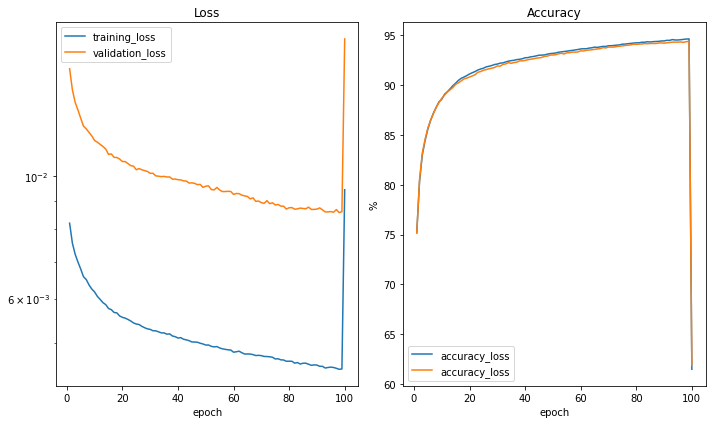

In [ ]:
plt.figure(figsize=(10, 6))
epoch_list = np.arange(1, epochs+1)
plt.subplot(1, 2,  1)
plt.semilogy(epoch_list, error_train_list, label = 'training_loss')
plt.semilogy(epoch_list, error_valid_list, label = 'validation_loss')
plt.legend()
plt.xlabel('epoch')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(epoch_list, accuracy_train_list*100, label = 'accuracy_loss')
plt.plot(epoch_list, accuracy_valid_list*100, label = 'accuracy_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('%')
plt.title('Accuracy')
plt.tight_layout()
plt.savefig('./sgd_1.jpg')
plt.show()